# Exercise 3: Digit Recognizer task
### Objective
In this exercise, the goal is to correctly identify digits from a dataset of handwritten images.


## Step 1: Initialization

### Library imports

In [140]:
import sys
import time
import scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Dataset loading

In [141]:
f = open("digit_recognizer_dataset.csv")
digits = pd.read_csv(f)

## Step 2: Define Problem

Digit Recognizer task:

Initially, the goal is to correctly identify digits from a dataset of handwritten images. 

Later, after experimenting with various models and settings, the best model for the dataset needs to be identified.

## Step 3: Exploratory Analysis

### Dataset Shape

In [142]:
digits.shape

(42000, 785)

### Dataset Head

In [143]:
digits.head()

label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0         0         0         0   
3       0  ...         0         0         0         0         0         0   
4       0  ...         0         0         0         0         0         0   

   pixel780  pixel781  pixel782  pixel783  
0         0         0         0         0  
1         0         0         0         0  
2         0         0         0         0  
3         0         0         0         0  
4         0         0         0         0  

[5 rows x 785 columns]

### Class Distribution
Identify how many instances exist in each class (digits from 0 to 9). More samples available for digit: 1

In [144]:
distr = digits.groupby('label').size()
distr

label
0    4132
1    4684
2    4177
3    4351
4    4072
5    3795
6    4137
7    4401
8    4063
9    4188
dtype: int64

## Step 4: Prepare Data
No need for data preparation. Dataset is ready for feature engineering.

## Step 5: Feature Engineering
Feature selection/feature engineering (as in new features)/data transformations.

### Remove columns with zero information

In [145]:
digits = digits.loc[:, (digits.sum(axis=0) != 0)]
digits.shape

(42000, 709)

### Create data and target arrays (X, Y)

In [146]:
array = digits.values
X = array[:,1:709]
Y = array[:,0]
print("Sample shape: " + str(X.shape))
print("Target shape: " + str(Y.shape))

Sample shape: (42000, 708)
Target shape: (42000,)


### Normalize X
Finally, it was assumed there was no need for normalization for the current problem. 

In [147]:
# X = X / 255

### Reduce dimensions (PCA)

In [153]:
# Feature Extraction with PCA
from sklearn.decomposition import PCA
# Initialise PCA
pca = PCA(n_components=50)
# Fit PCA
fit = pca.fit(X)
# Transform the array
X_PCA = pca.transform(X)

In [154]:
X_PCA.shape

(42000, 50)

## Cross Validation
Cross-validation method will be used to evaluate accuracy.

In [155]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
num_folds = 10
seed = 7
kfold = KFold(n_splits=num_folds, random_state=seed)

## Step 6: Algorithm Selection
Play with various classification algorithms and evaluate performance for each one of them.

### Models initialization

In [157]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=3)

In [158]:
# from sklearn.tree import DecisionTreeClassifier
# model = DecisionTreeClassifier()

In [159]:
# from sklearn.linear_model import LogisticRegression
# model = LogisticRegression()

In [160]:
# from sklearn.naive_bayes import GaussianNB
# model = GaussianNB()

In [161]:
# from sklearn.svm import SVC
# model = SVC()

In [162]:
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# model = LinearDiscriminantAnalysis()

In [163]:
# from sklearn.dummy import DummyClassifier
# model = DummyClassifier(strategy='stratified')

### Scoring function
According to kaggle (where dataset comes from) the metric selected should be accuracy: "The evaluation metric for this contest is the categorization accuracy, or the proportion of test images that are correctly classified."

In [164]:
scoring = 'accuracy'

### Evaluate models

In [165]:
start_time = time.time()
result = cross_val_score(model, X_PCA, Y, cv=kfold, scoring=scoring, n_jobs=-1)
print("%f (+/- %f)" % (result.mean(), result.std()))
print("%s minutes" % str((time.time() - start_time)/60))

0.974619 (+/- 0.002534)
0.6231106678644817 minutes


## Step 7: Model Training
Improve performance by hyperparameter optimisation.

### Hyperparameter optimisation
Try different numbers of neighbors for kNN algorithm (GridSearchCV) to find the one results to best accuracy.

In [42]:
from sklearn.model_selection import GridSearchCV
# Create list of neighbors
neighbors = list(range(1,11)) 
# Initialise grid search
#  > Estimator: kNN
#  > Parameter: n_neighbors (1-10)
#  > Scoring: Accuracy
#  > Cross validation: 10-fold
#  > Jobs: -1 (all available CPUs)
grid = GridSearchCV(estimator=model, param_grid=dict(n_neighbors=neighbors), scoring=scoring, n_jobs=-1, cv=kfold)
# Fit model
grid.fit(X_PCA, Y) 
# List of accuracies (results)
accuracies = grid.cv_results_['mean_test_score'] 

GridSearchCV(cv=KFold(n_splits=10, random_state=7, shuffle=False),
       error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

### Plot accuracies over neighbors

'Best Accuracy: 0.974643'

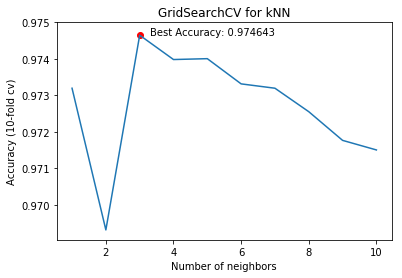

In [105]:
ac_str = "Best Accuracy: " + str(round(accuracies[2], 6))
fig = plt.figure()
plt.plot(neighbors, accuracies)
plt.title("GridSearchCV for kNN")
plt.xlabel("Number of neighbors")
plt.ylabel("Accuracy (10-fold cv)")
plt.scatter(neighbors[2], accuracies[2], color='r')
plt.text(neighbors[2] + neighbors[2]*0.1, accuracies[2], ac_str)
ac_str

In [109]:
# Save image for the report
fig.savefig('GridSearchCV_results.png')

## Step 8: Ensembles
Apply ensembles and check results.

### Bagging Classifier

In [121]:
from sklearn.ensemble import BaggingClassifier
bagging = BaggingClassifier(KNeighborsClassifier(n_neighbors=3), n_estimators=100, max_samples=0.5, max_features=0.5, n_jobs=-1)
# res = bagging.fit(X_PCA, Y)
# bagging.score(X_PCA,Y)
start_time = time.time()
resBagging = cross_val_score(bagging, X_PCA, Y, cv=kfold, scoring=scoring, n_jobs=-1)
print("%f (+/- %f)" % (resBagging.mean(), resBagging.std()))
print("%s minutes" % str((time.time() - start_time)/60))

0.972333 (+/- 0.002490)
15.066541047890981 minutes


### Boosting

In [120]:
from sklearn.ensemble import GradientBoostingClassifier
boosting = GradientBoostingClassifier(n_estimators=100, random_state=seed)
start_time = time.time()
resBoosting = cross_val_score(bagging, X_PCA, Y, cv=kfold, scoring=scoring, n_jobs=-1)
print("%f (+/- %f)" % (resBoosting.mean(), resBoosting.std()))
print("%s minutes" % str((time.time() - start_time)/60))

0.967357 (+/- 0.003855)
1.3313406149546305 minutes


## Step 9: Finalise Model
Create model from the entire (training) dataset.

In [167]:
final_model = KNeighborsClassifier(n_neighbors=3)
final_model.fit(X_PCA, Y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')